# Manual Parameter Scan

In [1]:
import itertools
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import fastjet
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import hist
from hist import Hist
from rich.table import Table
from rich.console import Console

In [2]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.style.use(hep.style.CMS)

In [3]:
vector.register_awkward()

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def inter_isolation(leptons_1, leptons_2, dR=1.6):
    """
    Compute the inter-isolation of each particle. It is supposed to work for one particle per event. The input is:
    - leptons_1: array of leptons for isolation calculation
    - leptons_2: array of all leptons in the events
    - dR: deltaR cut for isolation calculation
    """
    a, b = ak.unzip(ak.cartesian([leptons_1, leptons_2]))
    deltar_mask = a.deltaR(b) < dR
    return (ak.sum(b[deltar_mask].pt, axis=-1) - leptons_1.pt) / leptons_1.pt

def muon_filter(events, nMuons=4):
    """
    Filter events after the TripleMu trigger.
    Cleans muons and electrons.
    Requires at least nMuons with mediumId, pt, dxy, dz, and eta cuts.
    """
    muons = events.Muon
    electrons = events.Electron
    clean_muons = (
        (events.Muon.mediumId)
        & (events.Muon.pt > 3)
        & (abs(events.Muon.dxy) <= 0.02)
        & (abs(events.Muon.dz) <= 0.1)
        & (abs(events.Muon.eta) < 2.4)
    )
    clean_electrons = (
        (events.Electron.mvaFall17V2noIso_WPL)
        & (events.Electron.pt > 3)
        & (
            abs(events.Electron.dxy)
            < 0.05 + 0.05 * (abs(events.Electron.eta) > 1.479)
        )
        & (
            abs(events.Electron.dz)
            < 0.10 + 0.10 * (abs(events.Electron.eta) > 1.479)
        )
        & ((abs(events.Electron.eta) < 1.444) | (abs(events.Electron.eta) > 1.566))
        & (abs(events.Electron.eta) < 2.5)
    )
    muons = muons[clean_muons]
    electrons = electrons[clean_electrons]
    select_by_muons = ak.num(muons, axis=-1) >= nMuons
    events = events[select_by_muons]
    muons = muons[select_by_muons]
    electrons = electrons[select_by_muons]
    return events, electrons, muons

In [6]:
lumi = 59817.406
xsec_125 = 45.2

In [7]:
# Some commone paths
xrd_path = 'root://cmseos.fnal.gov//store/user/chpapage/SUEP_high_temp/2018/NANOAOD_merged/'
dataset = lambda mD, temp, decay: f"step_NANOAOD_mMed-125_mDark-{mD}_temp-{temp}_decay-{decay}_13TeV-pythia8.root"

In [8]:
decays = ['darkPho', 'darkPhoHad']
scan_points = [(2,8), (4,16), (8,8), (8,16), (8,32)]

In [5]:
cutflows = {}
pt_leading = []
pt_mean = []
h_i16 = []
for decay in decays:
    for mD, temp in scan_points:
        file = nanoevents.NanoEventsFactory.from_root(
            xrd_path + dataset(mD, temp, decay), 
            schemaclass=nanoevents.NanoAODSchema
        )
        events = file.events()
        name = f'mD-{mD}_T-{temp}_{decay}'
        print(f'Working on {name}')
        cutflows[name] = Hist.new.StrCategory(
            [
                'all',
                'trigger',  
                'nMu>4', 
                'nMu>=6',
                'nMu>=6 & I16>1',
                'nMu>=6 & ptMu<10', 
                'nMu>=6 & ptMu<10 & I16>1', 
            ], 
            name='cutflow', 
            label='cutflow',
        ).Weight()
        n_total = len(events)
        scale = lumi * xsec_125 / n_total
        cutflows[name].fill(len(events) * ['all'], weight=scale)
        # events = events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1]
        #events = events[events.HLT.TripleMu_10_5_5_DZ == 1]
        events = events[
            (events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1) | (events.HLT.TripleMu_10_5_5_DZ == 1)
        ]
        cutflows[name].fill(len(events) * ['trigger'], weight=scale)
        
        events, electrons, muons = muon_filter(events)
        muonsCollection = ak.zip(
            {
                "pt": muons.pt,
                "eta": muons.eta,
                "phi": muons.phi,
                "mass": muons.mass,
                "charge": muons.pdgId / (-13),
            },
            with_name="Momentum4D",
        )
        electronsCollection = ak.zip(
            {
                "pt": electrons.pt,
                "eta": electrons.eta,
                "phi": electrons.phi,
                "mass": electrons.mass,
                "charge": electrons.pdgId / (-11),
            },
            with_name="Momentum4D",
        )
        leptons = ak.concatenate([muonsCollection, electronsCollection], axis=-1)
        leading_muons = leptons[:, 0]
        i16 = inter_isolation(leading_muons, leptons)

        pt10_req = muons.pt < 10
        Muons_pt10 = muons[pt10_req]
        
        h = Hist.new.Regular(
            50, 
            2, 
            200, 
            transform=hist.axis.transform.log, 
            name=name, 
            label=name
        ).Double()
        h.fill(ak.fill_none(ak.pad_none(muons.pt, 2)[:,0], 0))
        pt_leading.append(h)
        
        h = Hist.new.Regular(
            50, 
            2, 
            200, 
            transform=hist.axis.transform.log, 
            name=name, 
            label=name
        ).Double()
        h.fill(ak.fill_none(ak.mean(muons.pt, axis=-1), 0))
        pt_mean.append(h)

        h = Hist.new.Regular(
            50, 
            0, 
            20,
            name=name, 
            label=name
        ).Double()
        h.fill(i16)
        h_i16.append(h)
        
        nMu4 = ak.num(muons) > 4
        nMu6 = ak.num(muons) >= 6
        nMu6_pt10 = ak.num(Muons_pt10) >= 6
        nMu6_I16 = (ak.num(muons) >= 6) & (i16 > 1)
        nMu6_pt10_I16 = (ak.num(Muons_pt10) >= 6) & (i16 > 1)

        cutflows[name].fill(ak.sum(nMu4) * ['nMu>4'], weight=scale)
        cutflows[name].fill(ak.sum(nMu6) * ['nMu>=6'], weight=scale)
        cutflows[name].fill(ak.sum(nMu6_I16) * ['nMu>=6 & I16>1'], weight=scale)
        cutflows[name].fill(ak.sum(nMu6_pt10) * ['nMu>=6 & ptMu<10'], weight=scale)
        cutflows[name].fill(ak.sum(nMu6_pt10_I16) * ['nMu>=6 & ptMu<10 & I16>1'], weight=scale)

NameError: name 'decays' is not defined

Text(0, 1, 'a.u.')

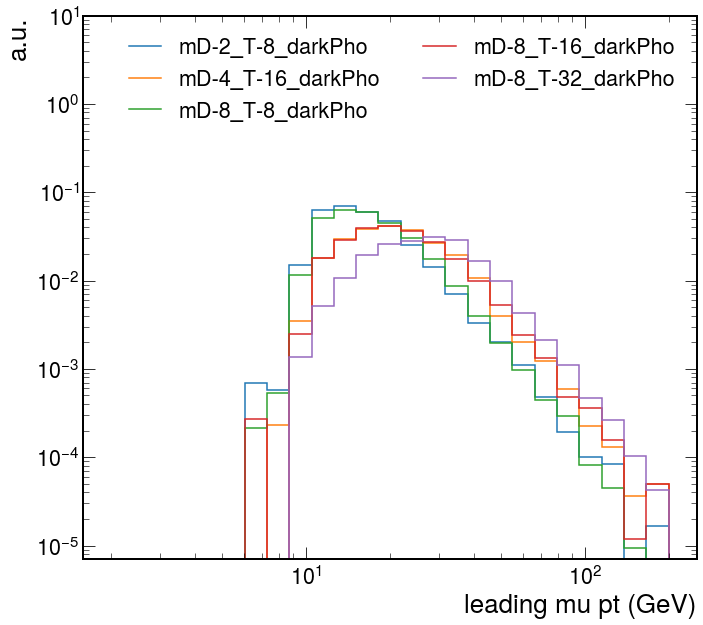

In [10]:
fig, ax = plt.subplots(figsize=(11, 10))
for h in pt_leading:
    if 'darkPhoHad' in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("leading mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

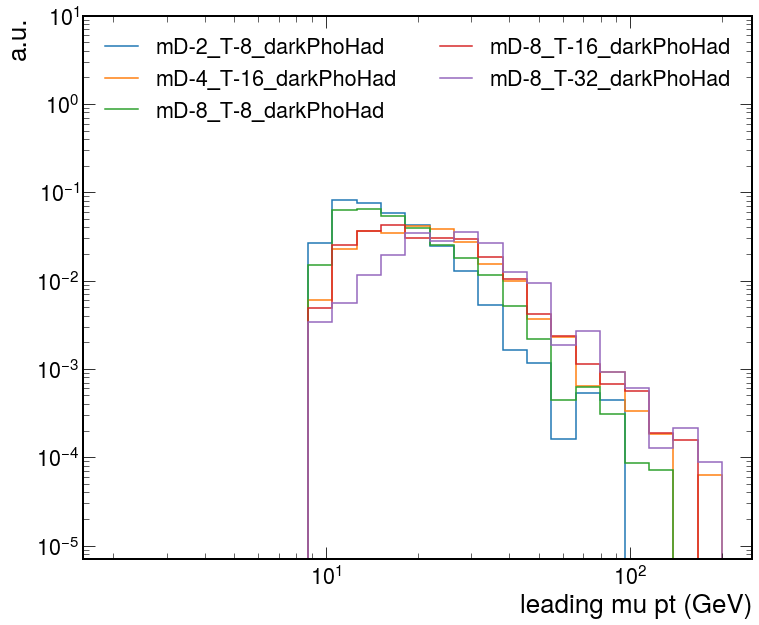

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in pt_leading:
    if 'Had' not in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("leading mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

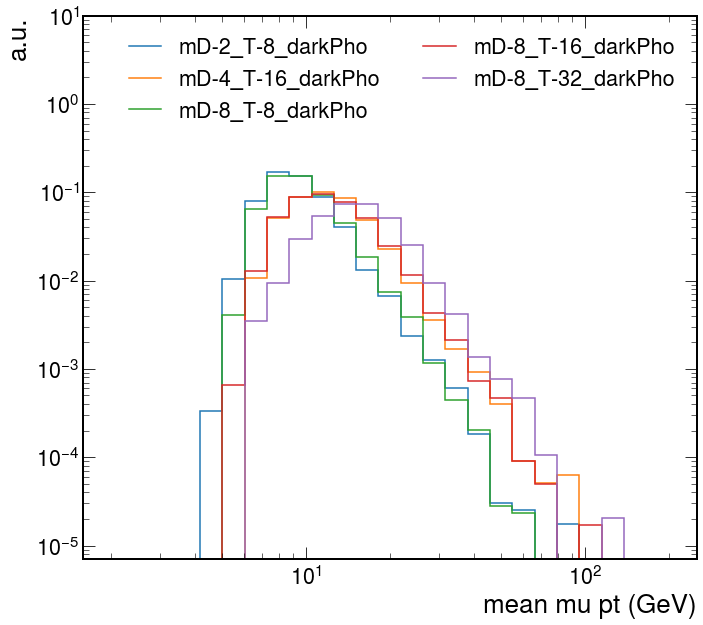

In [13]:
fig, ax = plt.subplots(figsize=(11, 10))
for h in pt_mean:
    if 'darkPhoHad' in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("mean mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

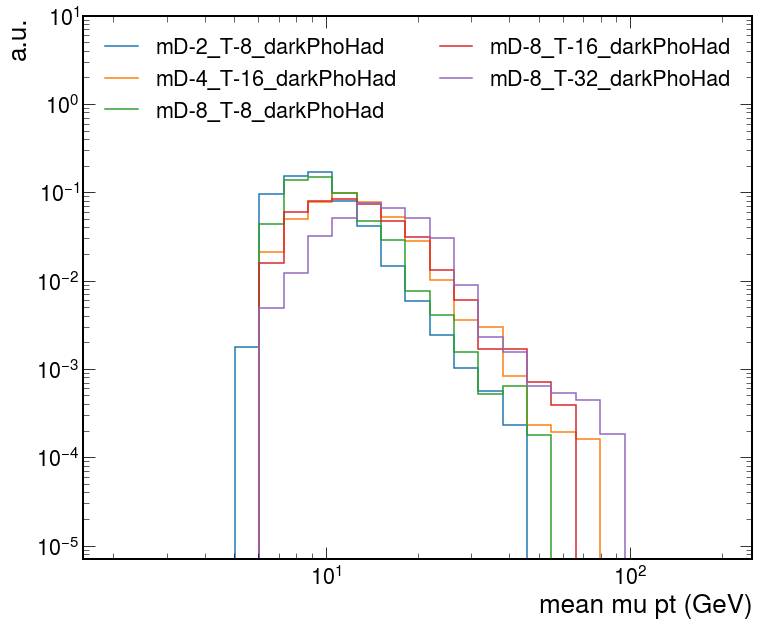

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in pt_mean:
    if 'Had' not in h.axes.label[0]:
        continue
    hep.histplot(h[::2j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(0.7e-5, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("mean mu pt (GeV)")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

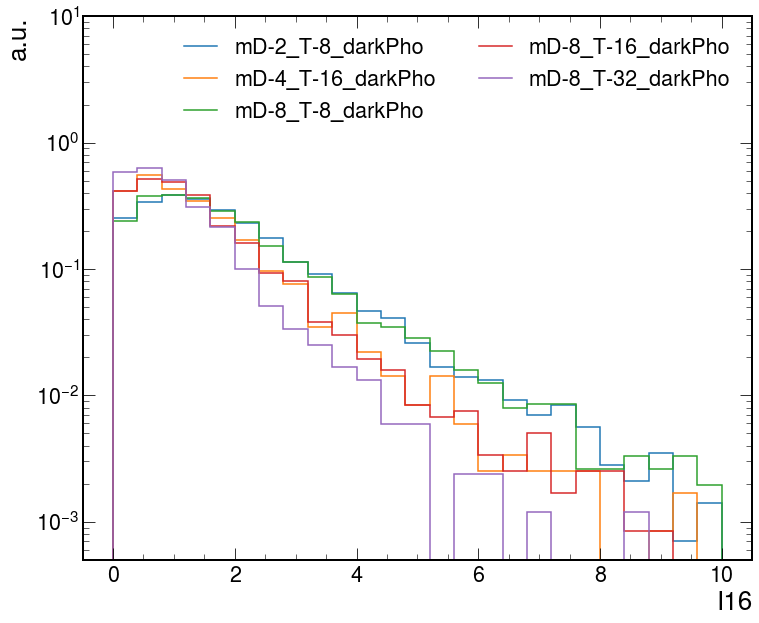

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in h_i16:
    if 'Had' in h.axes.label[0]:
        continue
    hep.histplot(h[:10j:1j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(5e-4, 1e1)
plt.yscale('log')
plt.xlabel("I16")
plt.ylabel("a.u.")

Text(0, 1, 'a.u.')

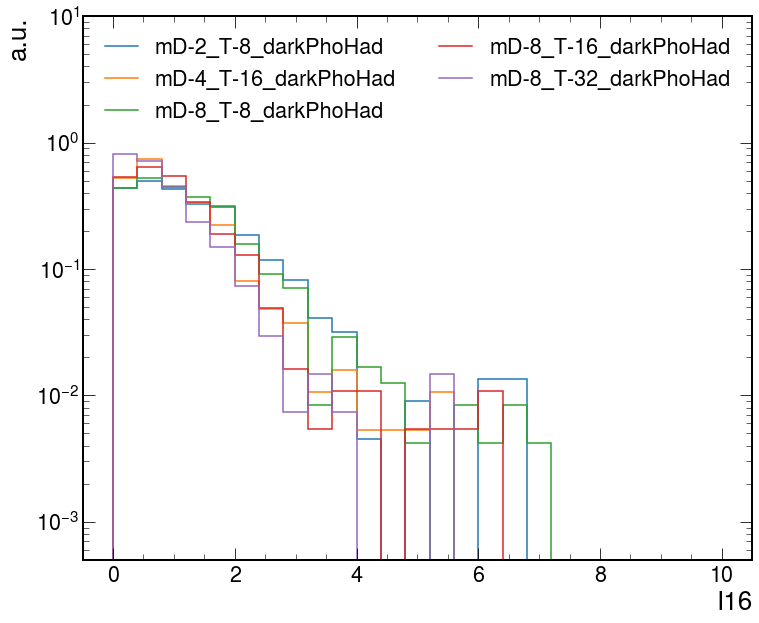

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
for h in h_i16:
    if 'Had' not in h.axes.label[0]:
        continue
    hep.histplot(h[:10j:1j], label=h.axes.label[0], density=True, yerr=False)
plt.legend(ncol=2)
plt.ylim(5e-4, 1e1)
plt.yscale('log')
plt.xlabel("I16")
plt.ylabel("a.u.")

### Inter-isolation

In [41]:
events, muons, electrons = muon_filter(events)
muonsCollection = ak.zip(
    {
        "pt": muons.pt,
        "eta": muons.eta,
        "phi": muons.phi,
        "mass": muons.mass,
        "charge": muons.pdgId / (-13),
    },
    with_name="Momentum4D",
)
electronsCollection = ak.zip(
    {
        "pt": electrons.pt,
        "eta": electrons.eta,
        "phi": electrons.phi,
        "mass": electrons.mass,
        "charge": electrons.pdgId / (-11),
    },
    with_name="Momentum4D",
)
leptons = ak.concatenate([muonsCollection, electronsCollection], axis=-1)
leading_muons = leptons[:, 0]
i16 = inter_isolation(leading_muons, leptons)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f3dca892250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

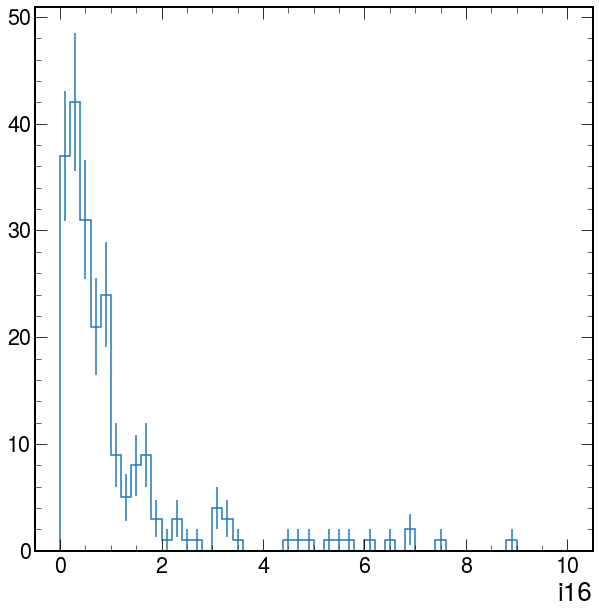

In [47]:
Hist.new.Reg(50, 0 ,10, name="i16", label="i16").Double().fill(i16).plot()

### Cutflow tables

In [51]:
cutflows['mD-8_T-32_darkPhoHad']

Hist(StrCategory(['all', 'trigger', 'nMuon >= 4', 'nMuon >= 6', 'nMuon >= 4 &\n pt_mu < 10', 'nMuon >= 6 &\n pt_mu < 10'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=2.83569e+06, variance=7.66699e+08)

In [52]:
list(range(4))

[0, 1, 2, 3]

In [16]:
table = Table(title="Cutflows 5_3_3_Mass3p8_DZ")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

year='2018'
samples = []
for decay in decays:
    for mD, temp in scan_points:
        samples += [f'mD-{mD}_T-{temp}_{decay}',]

n=3
cols_to_show = [3, 4, 5, 6]# list(range(n,n+3))
for i in cols_to_show:
    col_name = cutflows[samples[0]].axes[0].bin(i)
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

for sample in samples:
    string = []
    estring = []
    for i in range(cutflows[sample].size-1):
        s = f'{cutflows[sample][i].value:0.1f}'
        es = f'{math.sqrt(cutflows[sample][i].variance):0.1f}'
        if cutflows[sample][i].value > 1000:
            s = f'{cutflows[sample][i].value:0.1e}'
            es = f'{math.sqrt(cutflows[sample][i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample,
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show], 
    )

console = Console()
console.print(table)

                                          Cutflows                                           
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃     Sample      ┃      nMu>=6      ┃ nMu>=6 & I16>1  ┃ nMu>=6 & ptMu<10 ┃ nMu>=6 & ptMu<… ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mD-2_T-8_darkP… │ 5.6e+05 ± 1.2e+… │ 4.3e+05 ± 1.1e… │ 1.8e+05 ± 7.0e+… │ 1.5e+05 ± 6.4e… │
│ mD-4_T-16_dark… │ 2.9e+05 ± 9.0e+… │ 1.7e+05 ± 6.8e… │ 2.3e+04 ± 2.6e+… │ 1.7e+04 ± 2.2e… │
│ mD-8_T-8_darkP… │ 5.4e+05 ± 1.2e+… │ 4.1e+05 ± 1.1e… │ 1.5e+05 ± 6.4e+… │ 1.2e+05 ± 5.7e… │
│ mD-8_T-16_dark… │ 2.9e+05 ± 9.0e+… │ 1.7e+05 ± 7.0e… │ 2.5e+04 ± 2.7e+… │ 1.8e+04 ± 2.2e… │
│ mD-8_T-32_dark… │ 1.4e+05 ± 6.4e+… │ 6.6e+04 ± 4.4e… │ 2.9e+03 ± 9.3e+… │ 2.4e+03 ± 8.3e… │
│ mD-2_T-8_darkP… │ 3.6e+04 ± 3.1e+… │ 2.7e+04 ± 2.7e… │ 1.1e+04 ± 1.7e+… │ 9.4e+03 ± 1.6e… │
│ mD-4_T-16_dark… │ 1.4e+04 ± 2.0e+… │ 8.6e+03 ± 1.5e… │  551.8 ± 390.2   │  275.9 ± 275.9  │
│ mD-8_T-8_darkP… │ 3.1e+04 ± 3.0e+… │ 2.1e+04 ± 2.4e… │ 4.8e+03 ± 1.2e+… │ 4.2e+03 ± 1.1e… │
│ mD-8_T-16_dark… │ 1.1e+04 ± 1.7e+… │ 6.2e+03 ± 1.3e… │  811.1 ± 468.3   │  540.7 ± 382.4  │
│ mD-8_T-32_dark… │ 5.9e+03 ± 1.3e+… │ 1.6e+03 ± 6.6e… │    0.0 ± 0.0     │    0.0 ± 0.0    │
└─────────────────┴──────────────────┴─────────────────┴──────────────────┴─────────────────┘

In [18]:
table = Table(title="Cutflows 10_5_5_DZ")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

year='2018'
samples = []
for decay in decays:
    for mD, temp in scan_points:
        samples += [f'mD-{mD}_T-{temp}_{decay}',]

n=3
cols_to_show = [3, 4, 5, 6]# list(range(n,n+3))
for i in cols_to_show:
    col_name = cutflows[samples[0]].axes[0].bin(i)
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

for sample in samples:
    string = []
    estring = []
    for i in range(cutflows[sample].size-1):
        s = f'{cutflows[sample][i].value:0.1f}'
        es = f'{math.sqrt(cutflows[sample][i].variance):0.1f}'
        if cutflows[sample][i].value > 1000:
            s = f'{cutflows[sample][i].value:0.1e}'
            es = f'{math.sqrt(cutflows[sample][i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample,
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show], 
    )

console = Console()
console.print(table)

                                     Cutflows 10_5_5_DZ                                      
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃     Sample      ┃      nMu>=6      ┃ nMu>=6 & I16>1  ┃ nMu>=6 & ptMu<10 ┃ nMu>=6 & ptMu<… ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mD-2_T-8_darkP… │ 5.1e+05 ± 1.2e+… │ 3.9e+05 ± 1.0e… │ 1.2e+05 ± 5.8e+… │ 9.8e+04 ± 5.2e… │
│ mD-4_T-16_dark… │ 2.9e+05 ± 9.1e+… │ 1.7e+05 ± 6.9e… │ 1.9e+04 ± 2.3e+… │ 1.2e+04 ± 1.9e… │
│ mD-8_T-8_darkP… │ 5.0e+05 ± 1.2e+… │ 3.7e+05 ± 1.0e… │ 1.1e+05 ± 5.4e+… │ 8.5e+04 ± 4.8e… │
│ mD-8_T-16_dark… │ 2.9e+05 ± 9.0e+… │ 1.7e+05 ± 7.0e… │ 2.1e+04 ± 2.4e+… │ 1.4e+04 ± 2.0e… │
│ mD-8_T-32_dark… │ 1.4e+05 ± 6.5e+… │ 6.8e+04 ± 4.5e… │ 1.5e+03 ± 6.6e+… │  881.7 ± 509.0  │
│ mD-2_T-8_darkP… │ 3.0e+04 ± 2.9e+… │ 2.2e+04 ± 2.5e… │ 5.5e+03 ± 1.2e+… │ 4.4e+03 ± 1.1e… │
│ mD-4_T-16_dark… │ 1.4e+04 ± 2.0e+… │ 8.8e+03 ± 1.6e… │  551.8 ± 390.2   │  275.9 ± 275.9  │
│ mD-8_T-8_darkP… │ 2.8e+04 ± 2.8e+… │ 1.8e+04 ± 2.3e… │ 1.7e+03 ± 6.9e+… │ 1.1e+03 ± 5.6e… │
│ mD-8_T-16_dark… │ 1.1e+04 ± 1.7e+… │ 6.2e+03 ± 1.3e… │  270.4 ± 270.4   │  270.4 ± 270.4  │
│ mD-8_T-32_dark… │ 6.5e+03 ± 1.3e+… │ 1.6e+03 ± 6.6e… │    0.0 ± 0.0     │    0.0 ± 0.0    │
└─────────────────┴──────────────────┴─────────────────┴──────────────────┴─────────────────┘

In [20]:
table = Table(title="Cutflows 5_3_3_Mass3p8_DZ or 10_5_5_DZ")
table.add_column("Sample", justify="center", style="cyan", no_wrap=True, width=22)

year='2018'
samples = []
for decay in decays:
    for mD, temp in scan_points:
        samples += [f'mD-{mD}_T-{temp}_{decay}',]

n=3
cols_to_show = [3, 4, 5, 6]# list(range(n,n+3))
for i in cols_to_show:
    col_name = cutflows[samples[0]].axes[0].bin(i)
    style = "green"
    if col_name == "all":
        style = "magenta"
    table.add_column(col_name, justify="center", style=style, no_wrap=True, width=22)

for sample in samples:
    string = []
    estring = []
    for i in range(cutflows[sample].size-1):
        s = f'{cutflows[sample][i].value:0.1f}'
        es = f'{math.sqrt(cutflows[sample][i].variance):0.1f}'
        if cutflows[sample][i].value > 1000:
            s = f'{cutflows[sample][i].value:0.1e}'
            es = f'{math.sqrt(cutflows[sample][i].variance):0.1e}'
        string += [s]
        estring += [es]
    table.add_row(
        sample,
        *[f'{string[i]} ± {estring[i]}' for i in cols_to_show], 
    )

console = Console()
console.print(table)

                           Cutflows 5_3_3_Mass3p8_DZ or 10_5_5_DZ                            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃     Sample      ┃      nMu>=6      ┃ nMu>=6 & I16>1  ┃ nMu>=6 & ptMu<10 ┃ nMu>=6 & ptMu<… ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mD-2_T-8_darkP… │ 5.8e+05 ± 1.3e+… │ 4.5e+05 ± 1.1e… │ 1.8e+05 ± 7.1e+… │ 1.5e+05 ± 6.4e… │
│ mD-4_T-16_dark… │ 3.0e+05 ± 9.2e+… │ 1.8e+05 ± 7.0e… │ 2.3e+04 ± 2.6e+… │ 1.7e+04 ± 2.2e… │
│ mD-8_T-8_darkP… │ 5.6e+05 ± 1.2e+… │ 4.2e+05 ± 1.1e… │ 1.5e+05 ± 6.4e+… │ 1.2e+05 ± 5.8e… │
│ mD-8_T-16_dark… │ 3.0e+05 ± 9.2e+… │ 1.8e+05 ± 7.1e… │ 2.5e+04 ± 2.7e+… │ 1.8e+04 ± 2.2e… │
│ mD-8_T-32_dark… │ 1.4e+05 ± 6.5e+… │ 7.0e+04 ± 4.5e… │ 2.9e+03 ± 9.3e+… │ 2.4e+03 ± 8.3e… │
│ mD-2_T-8_darkP… │ 3.8e+04 ± 3.2e+… │ 2.8e+04 ± 2.8e… │ 1.2e+04 ± 1.8e+… │ 9.7e+03 ± 1.6e… │
│ mD-4_T-16_dark… │ 1.4e+04 ± 2.0e+… │ 8.8e+03 ± 1.6e… │  551.8 ± 390.2   │  275.9 ± 275.9  │
│ mD-8_T-8_darkP… │ 3.2e+04 ± 3.0e+… │ 2.1e+04 ± 2.5e… │ 4.8e+03 ± 1.2e+… │ 4.2e+03 ± 1.1e… │
│ mD-8_T-16_dark… │ 1.2e+04 ± 1.8e+… │ 6.5e+03 ± 1.3e… │  811.1 ± 468.3   │  540.7 ± 382.4  │
│ mD-8_T-32_dark… │ 6.5e+03 ± 1.3e+… │ 1.6e+03 ± 6.6e… │    0.0 ± 0.0     │    0.0 ± 0.0    │
└─────────────────┴──────────────────┴─────────────────┴──────────────────┴─────────────────┘

In [74]:
test_collection = ak.pad_none(Muons, 4)

In [87]:
test_collection[0].pt > 3

<Array [True, True, True, None] type='4 * ?bool'>

In [78]:
highpt = ak.argsort(test_collection.pt, axis=1, ascending=False, stable=True)

In [79]:
highpt

<Array [[0, 1, 2, 3], [0, ... 4], [0, 1, 2, 3]] type='250 * var * ?int64'>

In [88]:
ak.where(test_collection.pt > 10, 1, 0)

<Array [[1, 1, 0, None], ... [1, 1, 1, 1]] type='250 * var * ?int64'>

## Punzi investigation

In [14]:
def S_min(B, a, b):
    return (
        b**2/2 + a*np.sqrt(B) + (b/2)*np.sqrt(b**2+4*a*np.sqrt(B)+4*B)
    )

def S_min_smooth(B, a, b):
    return (
        a**2/8 + 9*b**2/13 + a*np.sqrt(B) + (b/2)*np.sqrt(b**2+4*a*np.sqrt(B)+4*B)
    )

In [33]:
B = np.linspace(0, 2, 100)

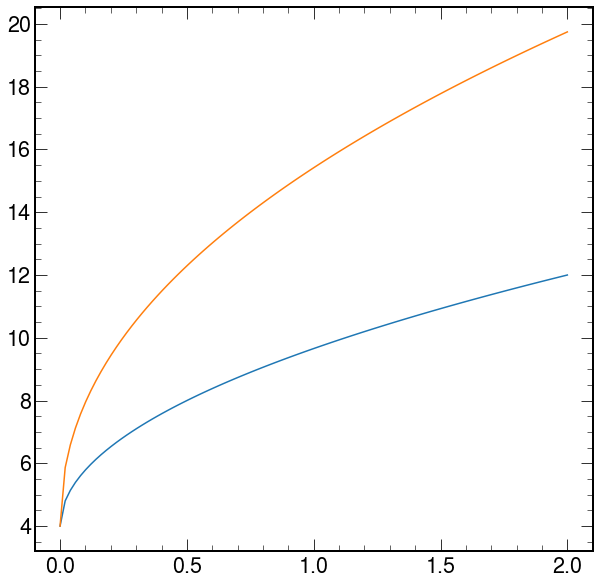

In [35]:
plt.plot(B, S_min(B=2*B, a=2, b=2))
plt.plot(B, S_min(B=2*B, a=5, b=2))

In [22]:
S_min_smooth(B=0, a=5, b=2)

7.894230769230769